# Qualitative Validation: Visualisation

A tutorial for the Visualisation class.

- plot_surface(X1, X2)
    - Plot the density function based on X1 and X2.
- plot_prob_fixed(X_fixed, y_range)
    - Plot probability density function given X_fixed across y_range.
- plot_violin(density1, density2)
    - Plot a violin to compare 2 densities.
- plot_prob_violin(X_fixed, X_tol)
    - Given X, plot a violin of y based on X within a tolerance, to compare between fitted and actual.
- plot_binned_violin()
    - Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.

# Synthetic Data

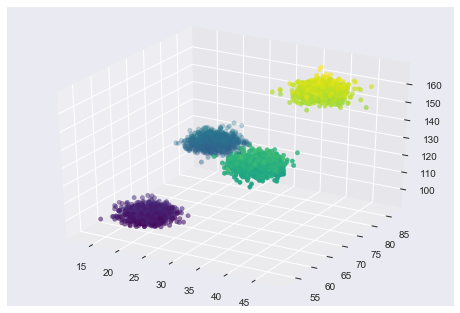

In [1]:
from data.synthetic import get_normal_data, plot_data

X, y = get_normal_data(1000, plot=True)

# Model: Gaussian Mixture Density Network

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
0 [NLL: 327.5203857421875]
2000 [NLL: 6.252025604248047]
4000 [NLL: 6.177170753479004]
6000 [NLL: 5.9426798820495605]
8000 [NLL: 4.618826389312744]
10000 [NLL: 3.652420997619629]
12000 [NLL: 2.7345964908599854]
14000 [NLL: 2.158916473388672]
16000 [NLL: 2.128394603729248]
18000 [NLL: 2.112623691558838]


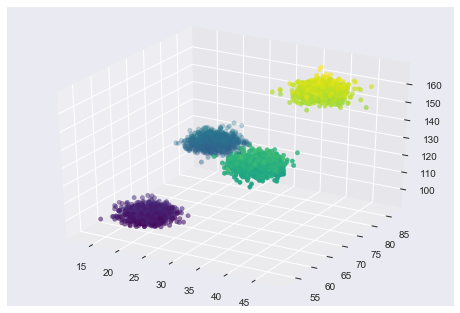

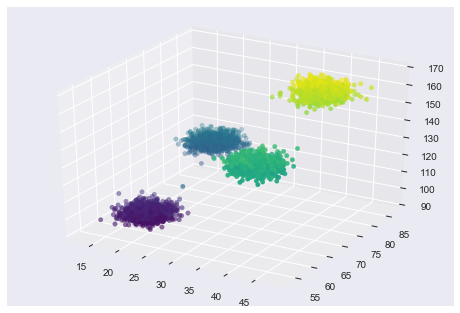

In [2]:
from model.gmm import GMM

gmm = GMM(x_features=2,
          y_features=1,
          n_components=32,
          n_hidden=32)
gmm.fit(X, y, epochs=20000, verbose=True, logdir='gmm_viz')

y_hat = gmm.predict(X)
plot_data(X, y)
plot_data(X, y_hat)

# Visualisation

In [4]:
from visualisation.visualisation import (plot_surface,
                                         plot_prob_fixed,
                                         plot_violin,
                                         plot_prob_violin,
                                         plot_binned_violin)

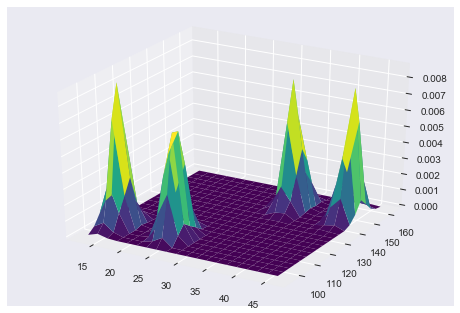

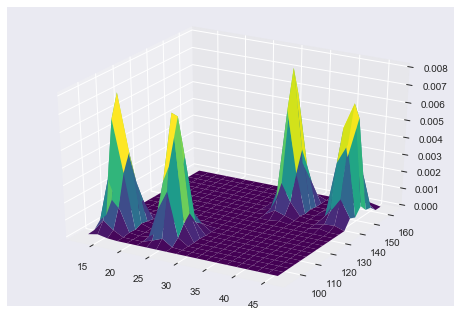

In [5]:
# Plot the density function based on X1 and X2
plot_surface(X[:,0], y[:,0], bins=20)
plot_surface(X[:,0], y_hat[:,0], bins=20)

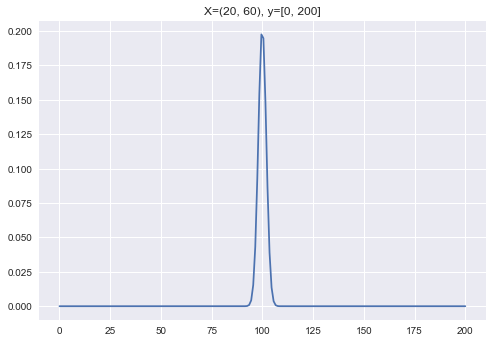

In [6]:
# Plot probability density function given X_fixed across y_range.
plot_prob_fixed(gmm, X_fixed=(20,60), y_range=[0,200], count=200)

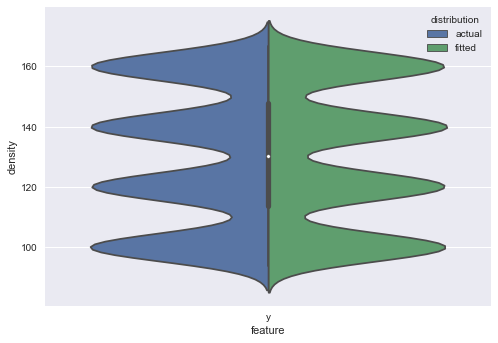

In [10]:
# Given 2 sets of data, plot a violin plot to compare the probability density function. 
plot_violin(y[:,0], y_hat[:,0], feature="y")

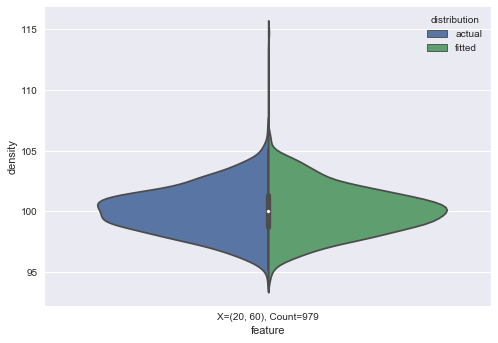

In [8]:
# Given X, plot a violin of y based on X within a tolerance, to compare the distribution between fitted and actual.
# X_tol represents the tolerance to which X data is binned to get the corresponding y.
# X_fixed represents the X fed into the model to sample y.
plot_prob_violin(gmm, X, y, X_fixed=(20,60), X_tol=(5,5))

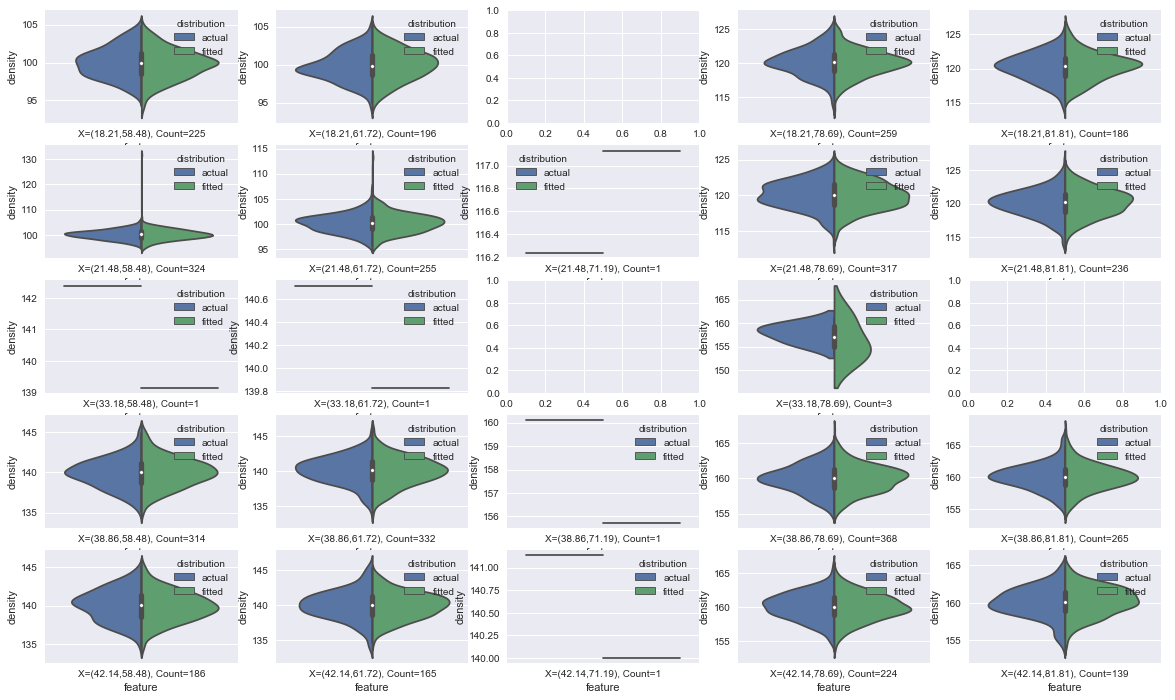

In [9]:
# Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.
# For the actual distribution, bin X and plot violin plots for the density of y.
# For the fitted distribution, input the mean of binned X and plot violin plots for the density of sampled y.
plot_binned_violin(gmm, X, y, bins=5)